In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages

import dpkt
import numpy as np
import time
import brewer2mpl

from AttackAnalysis import compute_effective_rate, compute_sending_rate
from analyze import compute_global_throughput, parse_file, removeOutliers
from read_conf import ReadHosts

In [2]:
host_to_ip, ip_to_host = ReadHosts('../experiment_conf/experiment_oak.conf')
interval = 5
root_dir = 'workdir/results-nping/'
figures_dir = 'paper-plots/exp2-2/'

In [3]:
linestyles = ['-', '--', '-.', ':']
markers = []
for m in Line2D.markers:
    try:
        if len(m) == 1 and m != ' ':
            markers.append(m)
    except TypeError:
        pass

styles = markers + [
    r'$\lambda$',
    r'$\bowtie$',
    r'$\circlearrowleft$',
    r'$\clubsuit$',
    r'$\checkmark$']

# Attacker Analysis

In [4]:
attacker_interval = 5

## No defense

In [25]:
attacker_rates_default = {}

for i in [1,2,3,4,5,6,7,8,9,10]:
    attacker = 'attacknode-' + str(i)
    attack_file_template = attacker + '-attack_log-tcpdump.cap'
    attacker_ip = host_to_ip[attacker]

    cap_file = root_dir + 'results-nping-nodefense/' + attack_file_template

    rate = compute_effective_rate(cap_file, attacker_interval, False)[attacker_ip]
    attacker_rates_default[attacker] = rate

+----------------------------------------------------+
Statistics for host 10.1.5.4
Total number of attempted connections: 	1
Total number of acked connections:     	1
Total number of failed connections:    	0
Total number of replies received:      	1
Average ACK rate:                      	0.2
+----------------------------------------------------+
+----------------------------------------------------+
Statistics for host 10.1.5.3
Total number of attempted connections: 	136709
Total number of acked connections:     	453
Total number of failed connections:    	136256
Total number of replies received:      	453
Average ACK rate:                      	1.29428571429
+----------------------------------------------------+
+----------------------------------------------------+
Statistics for host 10.1.5.4
Total number of attempted connections: 	136694
Total number of acked connections:     	535
Total number of failed connections:    	136159
Total number of replies received:      	535
Average 

## Cookies

In [5]:
attacker_rates_cookies = {}

for i in [1,2,3,4,5,6,7,8,9,10]:
    attacker = 'attacknode-' + str(i)
    attack_file_template = attacker + '-attack_log-tcpdump.cap'
    attacker_ip = host_to_ip[attacker]

    cap_file = root_dir + 'results-nping-cookies/' + attack_file_template

    rate = compute_effective_rate(cap_file, attacker_interval, False)[attacker_ip]
    attacker_rates_cookies[attacker] = rate

[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.3
Total number of attempted connections: 	534746
Total number of acked connections:     	8814
Total number of failed connections:    	129838
Total number of replies received:      	8813
Average ACK rate:                      	24.4833333333
+----------------------------------------------------+
+----------------------------------------------------+
Statistics for host 10.1.4.6
Total number of attempted connections: 	2
Total number of acked connections:     	2
Total number of failed connections:    	0
Total number of replies received:      	1
Average ACK rate:                      	0.4
+----------------------------------------------------+
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.4
Total number of attempted connections: 	533204
Total number of acked connections:     	793

## Challenges (k=2 , m=17)

In [26]:
attacker_rates_challenges = {}
max_len = 0
for i in [1,2,3,4,5,6,7,8,9,10]:
    attacker = 'attacknode-' + str(i)
    attack_file_template = attacker + '-attack_log-tcpdump.cap'
    attacker_ip = host_to_ip[attacker]

    cap_file = root_dir + 'results-nping-challenges-m17/' + attack_file_template

    rate = compute_effective_rate(cap_file, attacker_interval, False)[attacker_ip]
    max_len = np.maximum(max_len, len(rate))
    attacker_rates_challenges[attacker] = rate

+----------------------------------------------------+
Statistics for host 10.1.5.4
Total number of attempted connections: 	1
Total number of acked connections:     	1
Total number of failed connections:    	0
Total number of replies received:      	1
Average ACK rate:                      	0.2
+----------------------------------------------------+
+----------------------------------------------------+
Statistics for host 10.1.5.3
Total number of attempted connections: 	18914
Total number of acked connections:     	1121
Total number of failed connections:    	17793
Total number of replies received:      	6143
Average ACK rate:                      	2.31134020619
+----------------------------------------------------+
+----------------------------------------------------+
Statistics for host 10.1.5.4
Total number of attempted connections: 	14044
Total number of acked connections:     	974
Total number of failed connections:    	13070
Total number of replies received:      	3370
Average A

Average ACK rate reaching the server  6.55555555556


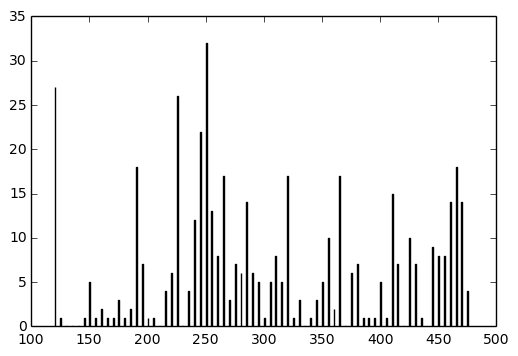

In [20]:
num_buckets = 360/attacker_interval
buckets = np.arange(120, 480, attacker_interval)

cumulative_rates = np.array([0]*num_buckets)
for att,rates in attacker_rates.items():
    curr_index = 0
    for r in rates:
        if curr_index >= num_buckets:
            break
        cumulative_rates[curr_index] += r
        curr_index += 1

plt.bar(buckets, cumulative_rates/attacker_interval)
print "Average ACK rate reaching the server ", np.average(cumulative_rates/attacker_interval)

## Putting things together

In [8]:
# change these for each section depending on your need
bmap = brewer2mpl.get_map('Set2', 'qualitative', 7)
colors = bmap.mpl_colors

params = {
   'axes.labelsize': 9,
   'text.fontsize': 10,
   'legend.fontsize': 9,
   'legend.handlelength': 2,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': False,
   'figure.figsize': [6, 2]
   }
plt.rcParams.update(params)

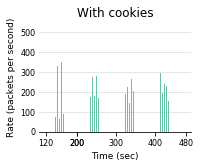

In [12]:
labels = ['challenges', 'cookies']
#labels=['cookies']
attacker_rates = {}
attacker_rates['cookies'] = attacker_rates_cookies
#attacker_rates['challenges'] = attacker_rates_challenges

fig = plt.figure()

num_buckets = 360/attacker_interval
buckets = np.arange(120, 480, attacker_interval)

k = 1
#titles = ['With challenges', 'With cookies']
titles = ['With cookies']
for label in labels:
    ax = fig.add_subplot(1,2,k)

    local_rates = attacker_rates[label]
    cumulative_rates = np.array([0]*num_buckets)
    for att,rates in local_rates.items():
        curr_index = 0
        for r in rates:
            if curr_index >= num_buckets:
                break
            cumulative_rates[curr_index] += r
            curr_index += 1
    
    ax.bar(buckets, cumulative_rates/attacker_interval,
            linewidth=2, color=colors[k-1])
    ax.set_xticks([120,200,200,300,400,480])
    ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_axisbelow(True)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(axis='x', direction='out')
    ax.tick_params(axis='y', length=0)
    plt.title(titles[k-1])
    ax.set_xlabel('Time (sec)')
    
    if k == 1:
        #ax.set_ylim(0,100)
        ax.set_ylabel('Rate (packets per second)')
    else:
        ax.set_yticks([200,400,600,800,1000])
    
    k += 1

#plt.savefig(figures_dir + 'attack_rates.pdf', bbox_inches='tight')